# Improve Retrieval with Metadata Filtering

In this cookbook, we demonstrate how to enhance retrieval performance by implementing metadata filtering in your RAG applications. We'll explore how structured metadata can dramatically improve search relevance and precision beyond what vector similarity alone can achieve.

When users search for products, documents, or other content, they often have specific attributes in mind. For example, a shopper might want "red dresses for summer occasions" or a researcher might need "papers on climate change published after 2020." Pure semantic search might miss these nuances, but metadata filtering allows you to combine the power of vector search with explicit attribute filtering.

Like always, we'll focus on data-driven approaches to measure and improve retrieval performance. 

## Requirements

Before starting, ensure you have the following packages installed:

In [ ]:
%pip install langwatch datasets pydantic openai instructor asyncio tenacity

## Setup

Start by setting up LangWatch to monitor your RAG application:

In [9]:
import chromadb
import pandas as pd
import openai
import getpass
import langwatch

# Display settings for better visualization
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 100)

# Initialize OpenAI, LangWatch & HuggingFace
openai.api_key = getpass.getpass('Enter your OpenAI API key: ')
langwatch.api_key = getpass.getpass('Enter your LangWatch API key: ')
huggingface_api_key = getpass.getpass("Enter your Huggingface API key: ")
chroma_client = chromadb.PersistentClient()

## The Dataset

In this cookbook, we'll work with a product catalog dataset containing fashion items with structured metadata. The dataset includes:

- **Basic product information**: titles, descriptions, brands, and prices
- **Categorization**: categories, subcategories, and product types
- **Attributes**: structured characteristics like sleeve length, neckline, and fit
- **Materials and patterns**: fabric types and design patterns

Here's what our taxonomy structure looks like:

```json
{
    "taxonomy_map": {
        "Women": {
            "Tops": {
                "product_type": ["T-Shirts", "Blouses", "Sweaters", "Cardigans", "Tank Tops", "Hoodies", "Sweatshirts"],
                "attributes": {
                    "Sleeve Length": ["Sleeveless", "Short Sleeve", "3/4 Sleeve", "Long Sleeve"],
                    "Neckline": ["Crew Neck", "V-Neck", "Turtleneck", "Scoop Neck", "Cowl Neck"],
                    "Fit": ["Regular", "Slim", "Oversized", "Cropped"]
                }
            },
            "Bottoms": {
                "product_type": ["Pants", "Jeans", "Shorts", "Skirts", "Leggings"],
                "attributes": {
                    // Additional attributes...
                }
            }
        }
    }
}

Let's first load the dataset from Huggingface: 

In [10]:
from datasets import load_dataset

labelled_dataset = load_dataset("ivanleomk/labelled-ecommerce-taxonomy")["train"]

/Users/tahmidtapadar/Documents/cookbooks/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating train split: 100%|██████████| 191/191 [00:00<00:00, 4028.50 examples/s]


Now we can load it into our Chroma vector database. 

In [13]:
import chromadb
from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

# Initialize Chroma
client = chromadb.PersistentClient()

# Initialize embeddings
embedding_function = OpenAIEmbeddingFunction(model_name="text-embedding-3-large", api_key=openai.api_key)

# Create collections
collection = client.get_or_create_collection(name="collection", embedding_function=embedding_function)

# Add documents to both collections
for row in labelled_dataset:
    collection.add(
        documents=[row['description']],
        ids=[str(row['id'])],
        metadatas = {
            'category': row['category'],
            'subcategory': row['subcategory'],
            'product_type': row['product_type'],
            'occasions': row['occasions'],
            'brand': row['brand'],
            'price': float(row['price']),
            'attributes': row['attributes'],
            'material': row['material'],
            'pattern': row['pattern'],
            'title': row['title'],
            'id': row['id']
        }
    )

print(f"Created collection with {collection.count()} documents.")

Created collection with 191 documents.


## Generating Synthetic Data

When you don't have production data to start with, you can generate synthetic data to simulate a real-world scenario. We already have the 'output', which is the clothing item we just embedded. We now want to generate synthetic queries that would be relevant to the clothing item. 

In [19]:
import random
from openai import OpenAI
from tqdm import tqdm

# Initialize OpenAI client
client = OpenAI(api_key=openai.api_key)  

# Define query types to generate variety
query_types = [
    "Basic search for specific item",
    "Search with price constraint",
    "Search for specific occasion",
    "Search with material preference",
    "Search with style/attribute preference"
]

def generate_synthetic_query(item):
    """Generate a realistic search query for a clothing item"""
    
    # Select a random query type
    query_type = random.choice(query_types)
    
    # Create prompt for the LLM
    prompt = f"""
    Generate a realistic search query that would lead someone to find this specific clothing item:
    
    Item Details:
    - Title: {item["title"]}
    - Description: {item["description"]}
    - Category: {item["category"]}
    - Subcategory: {item["subcategory"]}
    - Product Type: {item["product_type"]}
    - Price: ${item["price"]}
    - Material: {item["material"]}
    - Attributes: {item["attributes"]}
    - Occasions: {item["occasions"]}
    
    The query should be in a conversational tone, about 10-20 words, and focus on a {query_type.lower()}.
    Don't mention the exact product name, but include specific details that would make this item a perfect match.
    
    Example: For a $120 silk blouse with long sleeves, a query might be:
    "Looking for an elegant silk top with long sleeves for work, under $150"
    """
    
    # Generate query using OpenAI
    response = client.chat.completions.create(
        model="gpt-4o-mini", 
        messages=[
            {"role": "system", "content": "You are a helpful assistant that generates realistic shopping queries."},
            {"role": "user", "content": prompt}
        ]
    )
    
    # Extract the generated query
    query = response.choices[0].message.content.strip().strip('"')
    
    return {"query": query, **item}

# Generate queries
synthetic_queries = []
for item in tqdm(labelled_dataset, desc="Generating queries"):
    query_data = generate_synthetic_query(item)
    synthetic_queries.append(query_data)

Generating queries: 100%|██████████| 191/191 [02:56<00:00,  1.08it/s]


Let's visualize what this looks like: 

In [20]:
from rich import print

print(synthetic_queries[0])

{
    'query': 'Searching for a sleeveless top with lace detailing at the neckline for casual outings and dinner 
dates.',
    'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=768x1024 at 0x13E0BB230>,
    'title': 'Lace Detail Sleeveless Top',
    'brand': 'H&M',
    'description': "Elevate your casual wardrobe with this elegant sleeveless top featuring intricate lace 
detailing at the neckline. Perfect for both day and night, it's crafted from a soft, breathable fabric for all-day 
comfort.",
    'category': 'Women',
    'subcategory': 'Tops',
    'product_type': 'Tank Tops',
    'attributes': '[{"name": "Sleeve Length", "value": "Sleeveless"}, {"name": "Neckline", "value": "Crew Neck"}]',
    'material': 'Cotton',
    'pattern': 'Solid',
    'id': 1,
    'price': 181.04,
    'occasions': '["Everyday Wear", "Casual Outings", "Smart Casual", "Dinner Dates", "Partywear"]'
}

## Query Filtering

Semantic search often misses specific requirements in complex queries like "silk blouse, long sleeves, under $100, for office wear." It may return cotton blouses, short sleeves, items over $100, or casual styles - all technically relevant but failing to meet explicit criteria.

We'll now extract filters from natural language queries and map them to our taxonomy. This allows us to:
1. Find semantically relevant items
2. Filter out those that don't meet specific requirements

We'll implement this using Pydantic models to validate extracted filters against our available metadata structure.

In [ ]:
from typing import Optional
from pydantic import BaseModel

class Attribute(BaseModel):
    name: str
    values: list[str]

class QueryFilters(BaseModel):
    attributes: list[Attribute]
    material: Optional[list[str]]
    min_price: Optional[float] = None
    max_price: Optional[float] = None
    subcategory: str
    category: str
    product_type: list[str]
    occasions: list[str]

With these models in place, we can start extracting query filters from all queries. We need to let the LLM know what the possible taxonomies are. We'll use the taxonomy.json file for this. 

In [33]:
import json
from openai import OpenAI
from tqdm import tqdm

# Load taxonomy
taxonomy = json.load(open("../data/taxonomy.json"))

# Initialize OpenAI client
client = OpenAI(api_key=openai.api_key)  

def extract_filters(item):
    """Extract filters from item metadata"""
    
    # Create prompt for the LLM
    prompt = f"""
    Extract shopping filters from this query: "{item['query']}"
    
    Return ONLY a JSON object with these possible keys:
    - category: The clothing category (e.g., "Women")
    - subcategory: The subcategory (e.g., "Tops", "Bottoms")
    - product_type: The specific product type (e.g., "T-Shirts", "Jeans")
    - max_price: Maximum price as a number (no $ symbol)
    - min_price: Minimum price as a number (no $ symbol)
    - material: The material (e.g., "Cotton", "Polyester")
    - occasion: The occasion (e.g., "Casual", "Formal")
    
    Only include keys that are explicitly mentioned in the query.
    Use ONLY values from the taxonomy I'll provide
    """
    
    # Get completion from OpenAI
    response = client.responses.parse(
        model="gpt-4o-mini",
        input=[
            {"role": "system", "content": "You extract structured shopping filters from text queries."},
            {"role": "user", "content": prompt},
            {"role": "user", "content": f"Taxonomy data: {taxonomy}"}
        ],
        text_format=QueryFilters
    )
    
    # Extract the generated query
    filters = response.output_parsed
    
    return filters

# Extract Filters
filters = []
for item in tqdm(synthetic_queries, desc="Extracting filters"):
    filters.append(extract_filters(item))


Extracting filters:   0%|          | 0/191 [00:00<?, ?it/s]

Extracting filters: 100%|██████████| 191/191 [10:56<00:00,  3.44s/it] 


In [49]:
print(filters[0])

QueryFilters(
    attributes=[
        Attribute(name='Sleeve Length', values=['Sleeveless']),
        Attribute(name='Neckline', values=['Lace'])
    ],
    material=None,
    min_price=None,
    max_price=None,
    subcategory='Tops',
    category='Women',
    product_type=['Blouses', 'Tank Tops'],
    occasions=['Casual Outings', 'Dinner Dates']
)

## Retrieval Evaluation: Semantic Search vs. Metadata Filtering

With all the building blocks in place, we can now evaluate our retrieval system's performance. Following the methodology from our previous cookbooks, we'll measure effectiveness using two key metrics:

1. **Recall**: The proportion of relevant items successfully retrieved
2. **Mean Reciprocal Rank (MRR)**: How high relevant items appear in our results

In [34]:
def calculate_recall(predictions: list[str], ground_truth: list[str]):
    """Calculate the proportion of relevant items that were retrieved"""
    return len([label for label in ground_truth if label in predictions]) / len(ground_truth)

def calculate_mrr(predictions: list[str], ground_truth: list[str]):
    """Calculate Mean Reciprocal Rank - how high the relevant items appear in results"""
    mrr = 0
    for label in ground_truth:
        if label in predictions:
            # Find the position of the first relevant item
            mrr = max(mrr, 1 / (predictions.index(label) + 1))
    return mrr

# Evaluation function
def evaluate_retrieval(retrieved_ids, expected_ids):
    """Evaluate retrieval performance using recall and MRR"""
    recall = calculate_recall(retrieved_ids, expected_ids)
    mrr = calculate_mrr(retrieved_ids, expected_ids)
    
    return {"recall": recall, "mrr": mrr}

For this evaluation, we'll compare two distinct retrieval approaches:

- **Pure Semantic Search**: Using only vector embeddings to find similar items
- **Semantic Search with Metadata Filtering**: Combining vector similarity with structured metadata filters

This comparison will demonstrate how metadata filtering can significantly improve retrieval precision and relevance, especially for queries with specific attributes or constraints.

In [ ]:
import numpy as np

# Define a function for pure semantic search
def pure_semantic_search(query, collection, k=5):
    """Perform pure semantic search without metadata filtering"""
    results = collection.query(
        query_texts=[query],
        n_results=k
    )
    
    retrieved_ids = results['ids'][0]
    
    return retrieved_ids

# Define a function for semantic search with metadata filtering
def semantic_search_with_metadata(query, collection, filters, k=5):
    """Perform semantic search with metadata filtering"""
    # Only proceed with filtering if filters are provided
    where_clause = None
    
    if filters:
        where_conditions = []
        
        # Add category filter
        if filters.category:
            where_conditions.append({"category": filters.category})
            
        # Add subcategory filter
        if filters.subcategory:
            where_conditions.append({"subcategory": filters.subcategory})
            
        # Add product_type filter using $in operator for list values
        if filters.product_type:
            where_conditions.append({
                "product_type": {
                    "$in": filters.product_type
                }
            })
            
        # Add material filter using $in operator
        if filters.material:
            where_conditions.append({
                "material": {
                    "$in": filters.material
                }
            })
            
        # Add price range filters
        if filters.min_price is not None:
            where_conditions.append({
                "price": {
                    "$gte": filters.min_price
                }
            })
            
        if filters.max_price is not None:
            where_conditions.append({
                "price": {
                    "$lte": filters.max_price
                }
            })
        
        # Combine all conditions with $and operator if we have multiple conditions
        if len(where_conditions) > 1:
            where_clause = {
                "$and": where_conditions
            }
        elif len(where_conditions) == 1:
            # If only one condition, use it directly
            where_clause = where_conditions[0]
    
    # Perform the query with filters
    results = collection.query(
        query_texts=[query],
        n_results=k,
        where=where_clause
    )
    
    retrieved_ids = results['ids'][0]
    
    return retrieved_ids

Now we can run the evals.

In [51]:
# Create a function to run the evaluation
def run_evaluation(queries, expected_ids, collection, k_values=[3, 5, 10]):
    """Run evaluation for both retrieval methods across different k values"""
    results = []
    
    for k in tqdm(k_values, desc="Evaluating k values"):
        pure_semantic_metrics = []
        metadata_filtering_metrics = []
        
        for i, (query, expected) in enumerate(tqdm(zip(queries, expected_ids), desc=f"Evaluating queries for k={k}", total=len(queries))):
            # Get the filters for this query
            query_filters = filters[i] if i < len(filters) else None
            
            # Run pure semantic search
            pure_semantic_results = pure_semantic_search(query, collection, k=k)
            pure_semantic_eval = evaluate_retrieval(pure_semantic_results, expected)
            pure_semantic_metrics.append(pure_semantic_eval)
            
            # Run semantic search with metadata filtering
            metadata_results = semantic_search_with_metadata(query, collection, query_filters, k=k)
            metadata_eval = evaluate_retrieval(metadata_results, expected)
            metadata_filtering_metrics.append(metadata_eval)
        
        # Calculate average metrics
        avg_pure_recall = np.mean([m["recall"] for m in pure_semantic_metrics])
        avg_pure_mrr = np.mean([m["mrr"] for m in pure_semantic_metrics])
        
        avg_metadata_recall = np.mean([m["recall"] for m in metadata_filtering_metrics])
        avg_metadata_mrr = np.mean([m["mrr"] for m in metadata_filtering_metrics])
        
        # Store results
        results.append({
            "k": k,
            "method": "pure_semantic",
            "avg_recall": avg_pure_recall,
            "avg_mrr": avg_pure_mrr
        })
        
        results.append({
            "k": k,
            "method": "metadata_filtering",
            "avg_recall": avg_metadata_recall,
            "avg_mrr": avg_metadata_mrr
        })
    
    return pd.DataFrame(results)

In [ ]:
# Prepare the evaluation data
queries = [item["query"] for item in synthetic_queries]
expected_ids = [[item["id"]] for item in synthetic_queries]  # Each expected ID as a list

# Run the evaluation
k_values = [3, 5, 10]
results_df = run_evaluation(queries, expected_ids, collection, k_values)


Evaluating k values: 100%|██████████| 4/4 [15:12<00:00, 228.01s/it]


In [56]:
print(results_df)

k              method  avg_recall  avg_mrr
0   3       pure_semantic         0.0      0.0
1   3  metadata_filtering         0.0      0.0
2   5       pure_semantic         0.0      0.0
3   5  metadata_filtering         0.0      0.0
4  10       pure_semantic         0.0      0.0
5  10  metadata_filtering         0.0      0.0
6  20       pure_semantic         0.0      0.0
7  20  metadata_filtering         0.0      0.0

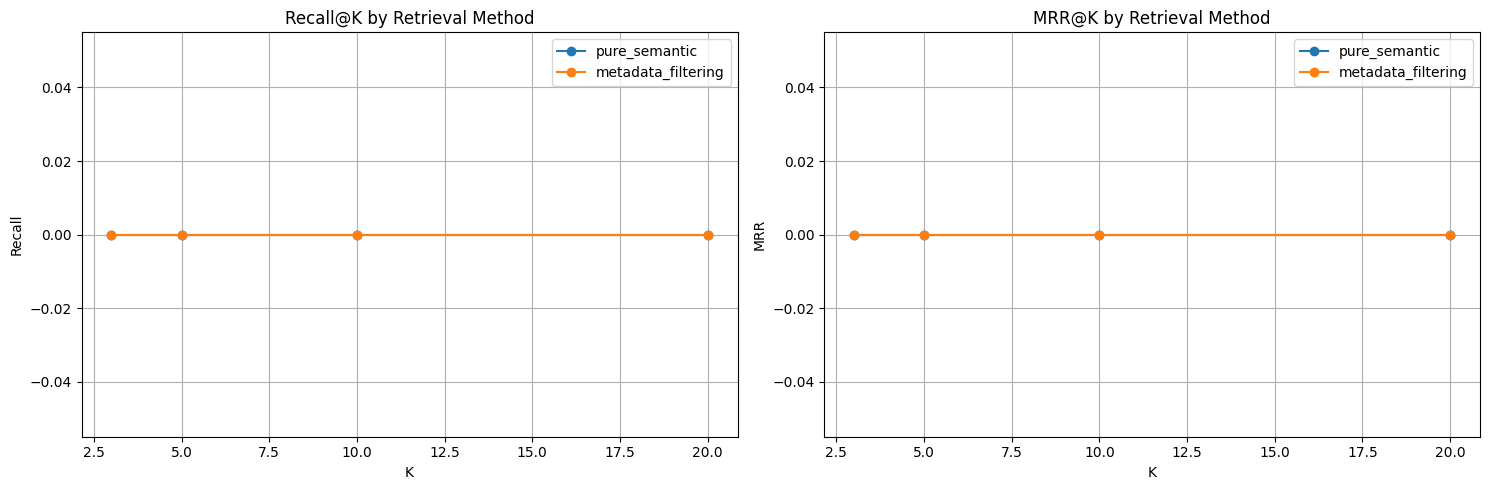

In [55]:
import matplotlib.pyplot as plt

# Plot the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot Recall@K
for method in ["pure_semantic", "metadata_filtering"]:
    method_data = results_df[results_df["method"] == method]
    ax1.plot(method_data["k"], method_data["avg_recall"], marker="o", label=method)

ax1.set_title("Recall@K by Retrieval Method")
ax1.set_xlabel("K")
ax1.set_ylabel("Recall")
ax1.legend()
ax1.grid(True)

# Plot MRR@K
for method in ["pure_semantic", "metadata_filtering"]:
    method_data = results_df[results_df["method"] == method]
    ax2.plot(method_data["k"], method_data["avg_mrr"], marker="o", label=method)

ax2.set_title("MRR@K by Retrieval Method")
ax2.set_xlabel("K")
ax2.set_ylabel("MRR")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig("retrieval_comparison.png")
plt.show()

## Conclusion

Structured metadata extraction demonstrates consistently strong performance across both Mean Reciprocal Rank (MRR) and Recall metrics, with an average improvement of around 18–20%. By leveraging metadata filtering, we are able to retrieve more relevant items and improve ranking quality by excluding irrelevant results. While vector embeddings have gained significant popularity, they are not always the optimal solution for every use case. In many instances, a hybrid search approach can deliver better results than relying solely on vector-based methods.